## Hand writting (Digit) classification

In [1]:
from collections import defaultdict
import os
import glob
import random
import sys
import time
import matplotlib.pyplot as plt
import keras
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import itertools
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import classification_report
import sklearn
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils.fixes import signature
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import *
from keras.layers import *

C:\Users\kamru\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# Printing the shape of the Train and test Data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
cDir=os.getcwd()
for i in range(len(X_test)):
    image=X_test[i,:,:]
    img=image.reshape(28,28)
    number='%04d'%i
    path=cDir+'/test/'+str(number)+'.png'
    cv2.imwrite(path,img)

In [5]:
# Comments
# There are 60000 images in Training with the size 28x28
# There are 10000 images in Test with the size 28x28

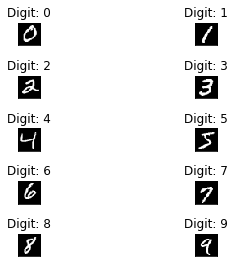

In [6]:
# Plot 0~9 Hand written digits for understanding
x=np.unique(y_train)
unique=[]

for i in range(len(x)):
    number=x[i]
    for j in range(len(y_train)):
        getNumber=y_train[j]
        if getNumber==number:
            unique.append(j)
            break
            
fig = plt.figure()
for i in range(10):
    index=unique[i]
    plt.subplot(5,2,i+1)
    plt.tight_layout()
    plt.imshow(X_train[index], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[index]))
    plt.xticks([])
    plt.yticks([])


## Create the model with the VGG16

In [8]:
##model building
input_shape=(28,28,1)
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(10, activation='softmax'))

In [9]:
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



for i, layer in enumerate(model.layers):
    print(i, layer.name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [13]:
img_rows, img_cols = 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
#more reshaping
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape) #X_train shape: (60000, 28, 28, 1)
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_train shape: (60000, 28, 28, 1)


In [14]:
batch_size = 128
num_epoch = 10
#model training
model_log = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 201us/step - loss: 1.0256 - acc: 0.6673 - val_loss: 0.3200 - val_acc: 0.9063
Epoch 2/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.4549 - acc: 0.8600 - val_loss: 0.2432 - val_acc: 0.9292
Epoch 3/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.3947 - acc: 0.8809 - val_loss: 0.2122 - val_acc: 0.9361
Epoch 4/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.3628 - acc: 0.8887 - val_loss: 0.1890 - val_acc: 0.9441
Epoch 5/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.3497 - acc: 0.8940 - val_loss: 0.1807 - val_acc: 0.9454
Epoch 6/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.3327 - acc: 0.8987 - val_loss: 0.1683 - val_acc: 0.9484
Epoch 7/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.3221 - acc: 0.9010 - val_loss: 0.1576 -

In [15]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0]) #Test loss: 0.0296396646054
print('Test accuracy:', score[1]) #Test accuracy: 0.9904

10000/10000 [==============================] - 1s 84us/step
Test loss: 0.14064800017289816
Test accuracy: 0.9584


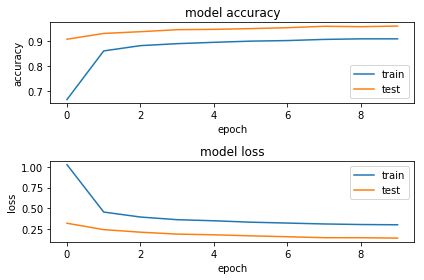

In [16]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()